# Comparing Machine Learning Techniques using Pipelines - Lab

## Introduction

In this lab, you'lll use a Dataset created by Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

The description of the data set is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to our product line.

A consistent analysis of the performance of our products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of our product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights Otto Group can generate about their product range.

In this lab, you'll use a data set containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product


## Objectives

You will be able to:
- Compare different classification techniques
- Construct pipelines in scikit-learn
- Use pipelines in combination with GridSearchCV

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. create a baseline model
4. create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

The data is stored in "otto_group.csv".

Things to do here:
- Check for NAs
- Check the distributions
- Check how many inputs there are
- ...

In [1]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv("otto_group.csv")
data.isna().sum()

id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
feat_5     0
feat_6     0
feat_7     0
feat_8     0
feat_9     0
feat_10    0
feat_11    0
feat_12    0
feat_13    0
feat_14    0
feat_15    0
feat_16    0
feat_17    0
feat_18    0
feat_19    0
feat_20    0
feat_21    0
feat_22    0
feat_23    0
feat_24    0
feat_25    0
feat_26    0
feat_27    0
feat_28    0
feat_29    0
          ..
feat_65    0
feat_66    0
feat_67    0
feat_68    0
feat_69    0
feat_70    0
feat_71    0
feat_72    0
feat_73    0
feat_74    0
feat_75    0
feat_76    0
feat_77    0
feat_78    0
feat_79    0
feat_80    0
feat_81    0
feat_82    0
feat_83    0
feat_84    0
feat_85    0
feat_86    0
feat_87    0
feat_88    0
feat_89    0
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64

In [ ]:
# Your code here
feat = data.loc[:, 'feat_1':'feat_30']
feat.hist(figsize=(30,20));

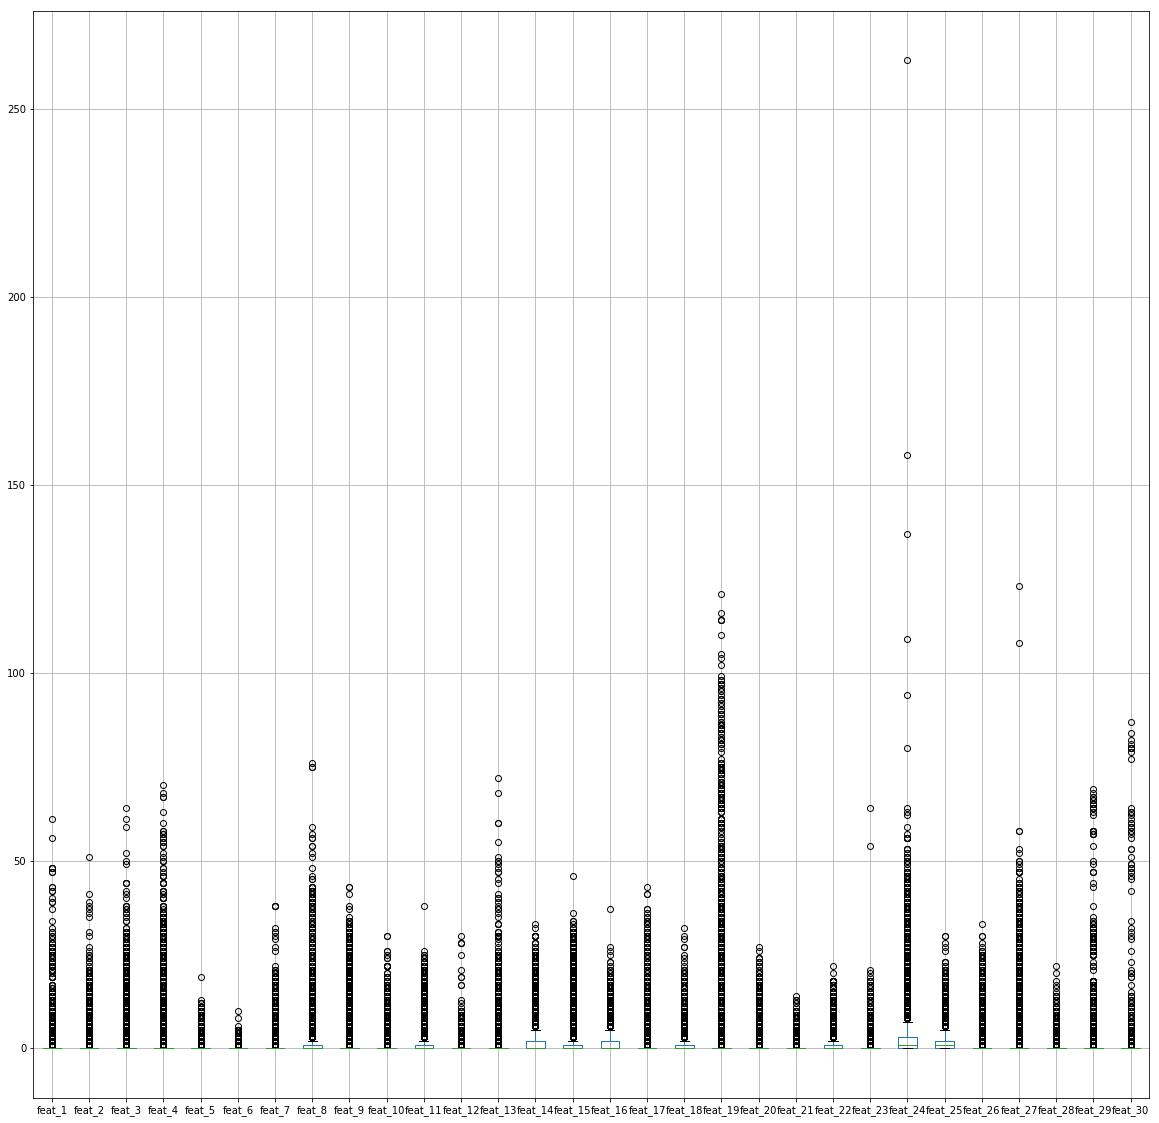

In [4]:
# Your code here
feat.boxplot(figsize=(20,20));

In [7]:
# Your code here
feat.isna().any().any()

False

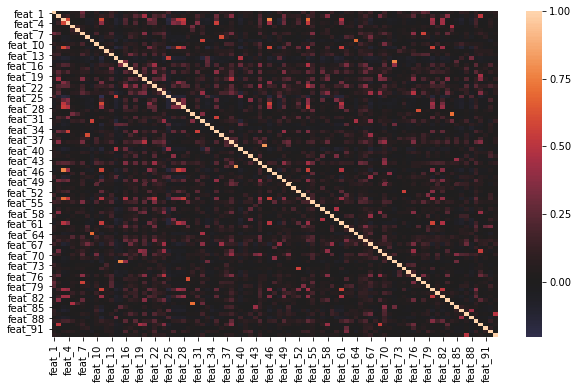

In [8]:
# Your code here
feat = data.loc[:, 'feat_1':'feat_93']

import seaborn as sns
plt.figure(figsize = (10, 6))
sns.heatmap(feat.corr(), center=0)


In [8]:
feat.shape

(61878, 93)

In [9]:
# Your code here
# Create correlation matrix
corr_matrix = feat.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Drop variables from table
feat.drop(columns=to_drop, inplace=True)
feat.shape

(61878, 93)

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

In [ ]:
# Your code here

Because the data is zero-inflated the boxplots look as shown above. Because there are this many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. More-over, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

In [ ]:
# Your code here

## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a heatmap.

In [10]:
# Your code here
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(feat)
principalComponents = pca_2.fit_transform(feat)
principalComponents = pca_3.fit_transform(feat)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

pca = PCA(n_components=27)
principalComponents = pca.fit_transform(feat)
print(np.sum(pca.explained_variance_ratio_))

0.7275129635700234
0.8886181531283778
0.9597943667739159
0.8003615466117191


Use PCA to downscale your features. Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

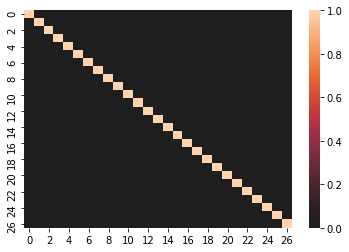

In [9]:
# Your code here
import seaborn as sns
sns.heatmap(pd.DataFrame(principalComponents).corr(), center=0);

In [11]:
# Your code here
y = data['target']
X = data.loc[:, 'feat_1':'feat_93']

## Create a train test split with a test size of 40%

This is a relatively big training set. Feel free to make it smaller (down to ~20%), but for an initial run you can try smaller training sets so the computation time is more manageable.

For now, simply use the original data and not the principal components. We looked at the PC's first to get a sense of our correlation structure, and to see how we can downsize our data without losing too much information. In what's next, you'll make PCA part of the pipeline!!

In [12]:
# Your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
# Your code here

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline
- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be the building a basic logistic regression model.

Make sure to fit the model using the training set, and test the result by obtaining the accuracy using the test set.

In [13]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [14]:
# Your code here
pipe_lr = Pipeline([('pca', PCA(n_components=27, random_state=18)),
         ('clf', LogisticRegression(random_state=18))])

# Fit the pipelines
pipe_lr.fit(X_train, y_train)

print(pipe_lr.score(X_test, y_test))

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7168713639301875


In [14]:
# Your code here
np.sum(pipe_lr.predict(X_test) == y_test)/len(y_test)

0.7168713639301875

## Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SCM
- One for a default decision tree
- One for a RandomForestClassifier

In [15]:
# Your code here

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler

pipe_svm = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(n_components=27, random_state=18)),
         ('clf', svm.SVC(random_state=18))])

pipe_tree = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(n_components=27, random_state=18)),
        ('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('scl', StandardScaler()),
    ('pca', PCA(n_components=27, random_state=18)),
        ('clf', RandomForestClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=18,
  shrinking=True, tol=0.001, verbose=False))])


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_...       min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'))])


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_...s='warn', n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Support Vector Machine pipeline test accuracy: 0.768
Decision Tree pipeline test accuracy: 0.670


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Random Forest pipeline test accuracy: 0.755


## Pipeline with grid search

Construct 3 pipelines with grid search
- one for support vector machines - make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!
- one for random forests - try to have around 40 different models
- one for the adaboost algorithm. 

### Gboost with GridSearch

In [19]:
# Your code here
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Construct pipeline
pipe_ab = Pipeline([('pca', PCA(n_components=27)),
            ('clf', AdaBoostClassifier(random_state = 123))])

# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': [30, 50, 70],
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_ab.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_ab.best_score_)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ................... clf__C=0.1, clf__kernel=linear, total=  27.1s
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.7s remaining:    0.0s
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ................... clf__C=0.1, clf__kernel=linear, total=  25.8s
[CV] clf__C=0.1, clf__kernel=linear ..................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ................... clf__C=0.1, clf__kernel=linear, total=  26.0s
[CV] clf__C=1, clf__kernel=linear ....................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ..................... clf__C=1, clf__kernel=linear, total=  41.1s
[CV] clf__C=1, clf__kernel=linear ....................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ..................... clf__C=1, clf__kernel=linear, total=  42.2s
[CV] clf__C=1, clf__kernel=linear ....................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ..................... clf__C=1, clf__kernel=linear, total=  41.3s
[CV] clf__C=10, clf__kernel=linear ...................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] .................... clf__C=10, clf__kernel=linear, total= 3.6min
[CV] clf__C=10, clf__kernel=linear ...................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] .................... clf__C=10, clf__kernel=linear, total= 3.0min
[CV] clf__C=10, clf__kernel=linear ...................................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] .................... clf__C=10, clf__kernel=linear, total= 2.8min
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=  47.5s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=  48.4s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=  48.3s
[CV] clf__C=1, clf__gamma=0.01, clf__kernel=rbf ......................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ....... clf__C=1, clf__gamma=0.01, clf__kernel=rbf, total=  39.6s
[CV] clf__C=1, clf__gamma=0.01, clf__kernel=rbf ......................


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Use your grid search object along with `.cv_results` to get the full result overview

In [ ]:
# Your code here


### Random Forest pipeline with grid search

In [ ]:
# Your code here

In [ ]:
# Your code here

## Adaboost

In [ ]:
# Your code here

## Note

Note that this solution is only one of many options. The results in the Random Forest and Adaboost models show that there is a lot of improvement possible tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You now got a lot of practice in. What algorithm would you choose and why?